In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#### Preparation

In [2]:
def Combination(n, r):
    return math.factorial(n)//math.factorial(n-r)//math.factorial(r)

def Binomial(param):
    N, p=param
    return [Combination(N, k)*pow(p, k)*pow(1-p, N-k) for k in range(N+1)]

def Binomials(list_n_p):
    #list_n_p: 2-dimensioin vector (shape=(n, 2))
    #list_n_p[i]: i-th setting for Binomial distribution.
    #list_n_p[i][0]: n of i-th Binomial dist.
    #list_n_p[i][1]: p of i-th Binomial dist.
    
    list_n_p=[list_n_p[i] for i in range(len(list_n_p)) if list_n_p[i][0]!=0]

    hist=Binomial(list_n_p[0])
    for i in range(len(list_n_p)-1):
        pre_prob=hist
        add_prob=Binomial(list_n_p[i+1])

        l=np.max([len(pre_prob), len(add_prob)])
        mx=len(pre_prob)+len(add_prob)-2

        #probability map
        prob_map=np.zeros((l, l))
        prob_map[:len(pre_prob), :len(add_prob)]=np.dot(np.array(pre_prob).reshape(-1, 1), np.array(add_prob).reshape(1, -1))

        #upper-left part of matrix
        hist_former=[np.sum([prob_map[i, s-i] for i in range(s+1)]) for s in range(l)]

        #lower-right part of matrix
        hist_latter=[np.sum([prob_map[-1-i, l-(minus-i)-1] for i in range(minus+1)]) for minus in range(l-1)]

        hist=hist_former+hist_latter[::-1]
        hist=hist[:mx+1]
        
    return hist

def Sum_Prob(list_A, list_B):
    l=np.max([len(list_A), len(list_B)])
    mx=len(list_A)+len(list_B)
    
    prob_map=np.zeros((l, l))
    prob_map[:len(list_A), :len(list_B)]=np.dot(np.array(list_A).reshape(-1, 1), np.array(list_B).reshape(1, -1))
    
    hist_former=[np.sum([prob_map[i, s-i] for i in range(s+1)]) for s in range(l)]
    hist_latter=[np.sum([prob_map[-1-i, l-(minus-i)-1] for i in range(minus+1)]) for minus in range(l-1)]
    
    hist=hist_former+hist_latter[::-1]
    hist=hist[:mx+1]
    
    return hist

class test:
    def __init__(self, n_total, distribution):
        self.n_total=n_total
        self.distribution=distribution
        self.n_a=np.nan
        self.n_b=np.nan
        self.KLd=np.nan
        self.edit_distribution()
        return
    
    def edit_distribution(self):
        total=np.sum(self.distribution)
        self.distribution=[self.distribution[i]/total for i in range(len(self.distribution))]
    
    def calc_n(self, p_a, p_b, detail=False):
        temp_n_a=0
        while temp_n_a<=self.n_total:
            temp_n_b=round(self.n_total-temp_n_a)
            temp_dist=np.zeros(self.n_total+1)
            for i in range(p_a.shape[0]):
                temp_dist+=np.array(Binomials([[temp_n_a, p_a[i]], [temp_n_b, p_b[i]]]))/p_a.shape[0]
                
            temp_dist=self.convert_dist2percentage(temp_dist)
            if np.abs(mean_dist(np.arange(101), temp_dist)-mean_dist(np.arange(0, 100, 5), self.distribution))<20:
                temp_dist_5=[np.sum(temp_dist[:6])]+[np.sum(temp_dist[5*(i+1)+1:5*(i+2)+1]) for i in range(19)]
                temp_KLd=KLdivergence(temp_dist_5, self.distribution)
                if detail==True:
                    plt.plot(np.arange(len(temp_dist_5))*5+5, temp_dist_5, label='temp_dist')
                    plt.plot(np.arange(len(temp_dist_5))*5+5, self.distribution, label='self.distribution')
                    plt.title('n_a='+str(temp_n_a)+', n_b='+str(temp_n_b)+', KLd='+str(temp_KLd))
                    plt.show()

                if self.KLd>temp_KLd or np.isnan(self.KLd):
                    self.KLd=temp_KLd
                    self.n_a=temp_n_a
                    
            else:
                if detail==True:
                    print('Skip: n_a='+str(temp_n_a)+', n_b='+str(temp_n_b))
                
            temp_n_a=round(temp_n_a+1)
                
        self.n_b=self.n_total-self.n_a
        return
    
    def convert_dist2percentage(self, dist):
        percentage=[0 for i in range(101)]
        for i in range(len(dist)):
            percentage[round(100*i/(len(dist)-1))]+=dist[i]
            
        return percentage
    
def KLdivergence(p, q):
    p_range=[p[i]>1e-12 for i in range(len(p))]
    q_range=[q[i]>1e-12 for i in range(len(q))]
    
    double_true=np.sum([1 if p_range[i]==True and q_range[i]==True else 0 for i in range(len(p))])
    if double_true>0:
        out=np.sum([p[i]*np.log(p[i]/q[i]) if p_range[i]==True and q_range[i]==True else 0 for i in range(len(p))])
    else:
        out=np.inf
        
    return out

def mean_dist(value, dist):
    return np.dot(value, dist)

#### Data preparation

In [3]:
#data preparation

rawdata=pd.read_csv('data/sample_distribution.csv', index_col=0)
thrs=[5*i for i in range(20)]

n_questions=[100, 50, 30, 30, 40]
n_tests=len(n_questions)
n_subjects=100
subjects=np.zeros((2, n_subjects))

#### (1) Calculate p_a from distribution['exam0']

In [4]:
def dist2data(dist, thresholds):
    output=np.array([])
    i=0
    while i<len(thresholds)-1:
        if dist[i]!=0:
            interval=(thresholds[i+1]-thresholds[i])/dist[i]
            output=np.r_[output, np.arange(thresholds[i]+interval, thresholds[i+1]+interval, interval)]
            
        i+=1
    return output

In [5]:
subjects[0, :]=dist2data(np.array(rawdata.loc['exam0']), thrs)
subjects[0, :]/=100

#### (2) Calculate n_a, n_b and KL divergence for each k and decide k.

In [6]:
for k in [0.4, 0.5, 0.6, 0.7, 0.8]:
    print('Calculation: k='+str(k))
    tests=[test(n_questions[i], np.array(rawdata.loc['exam'+str(i)])) for i in range(len(n_questions))]
    tests[0].n_a=n_questions[0]
    tests[0].n_b=0
    
    for i in range(n_tests-1):
        subjects[1]=k*subjects[0]
        tests[i+1].calc_n(subjects[0], subjects[1])
        print('tests['+str(i+1)+']: n_a='+str(tests[i+1].n_a)+', n_b='+str(tests[i+1].n_b)+', KLd='+str(tests[i+1].KLd))
        
    print()

Calculation: k=0.4
tests[1]: n_a=25, n_b=25, KLd=0.05712127270872972
tests[2]: n_a=22, n_b=8, KLd=0.12088312946347385
tests[3]: n_a=23, n_b=7, KLd=0.14012997534763
tests[4]: n_a=27, n_b=13, KLd=0.1350818925084391

Calculation: k=0.5
tests[1]: n_a=20, n_b=30, KLd=0.05518258667343094
tests[2]: n_a=20, n_b=10, KLd=0.12118126659063509
tests[3]: n_a=21, n_b=9, KLd=0.13876273055920496
tests[4]: n_a=24, n_b=16, KLd=0.13175553555935274

Calculation: k=0.6
tests[1]: n_a=13, n_b=37, KLd=0.0542293744854628
tests[2]: n_a=18, n_b=12, KLd=0.12308575784153497
tests[3]: n_a=19, n_b=11, KLd=0.1374538253135821
tests[4]: n_a=20, n_b=20, KLd=0.12929416875881794

Calculation: k=0.7
tests[1]: n_a=0, n_b=50, KLd=0.053189950160146195
tests[2]: n_a=13, n_b=17, KLd=0.12405369201322347
tests[3]: n_a=15, n_b=15, KLd=0.1365398748051609
tests[4]: n_a=13, n_b=27, KLd=0.12689183716487348

Calculation: k=0.8
tests[1]: n_a=0, n_b=50, KLd=0.2975581248090772
tests[2]: n_a=5, n_b=25, KLd=0.1250728206955276
tests[3]: n_a=8

#### (3) Get data with decided k

In [7]:
k=0.6

In [8]:
tests=[test(n_questions[i], np.array(rawdata.loc['exam'+str(i)])) for i in range(len(n_questions))]
tests[0].n_a=n_questions[0]
tests[0].n_b=0

for i in range(n_tests-1):
    subjects[1]=k*subjects[0]
    tests[i+1].calc_n(subjects[0], subjects[1])
    print('tests['+str(i+1)+']: n_a='+str(tests[i+1].n_a)+', n_b='+str(tests[i+1].n_b)+', KLd='+str(tests[i+1].KLd))

tests[1]: n_a=13, n_b=37, KLd=0.0542293744854628
tests[2]: n_a=18, n_b=12, KLd=0.12308575784153497
tests[3]: n_a=19, n_b=11, KLd=0.1374538253135821
tests[4]: n_a=20, n_b=20, KLd=0.12929416875881794


#### (4) Estimate scores of all subjects.

In [9]:
result=np.zeros(np.sum(n_questions)+1)
for i in range(n_subjects):
    As=[[tests[j].n_a, subjects[0, i]] for j in range(n_tests)]
    Bs=[[tests[j].n_b, subjects[1, i]] for j in range(n_tests)]
    params=As+Bs
    
    subj_dist=Binomials(params)
    result+=np.array(subj_dist)
    
result=n_subjects*result/np.sum(result)

#### (5) display histgram

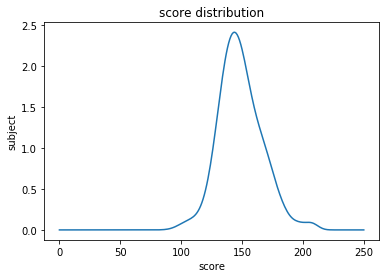

In [10]:
plt.plot(np.arange(result.shape[0]), result)
plt.xlabel('score')
plt.ylabel('subject')
plt.title('score distribution')
plt.show()

#### (6) Estimate the rank.

In [11]:
X=150
print('Rank(score='+str(X)+') = '+str(np.int(np.sum(result[X:]))+1))

Rank(score=150) = 45
